**Subject:** Machine and Deep Learning 2023

*  **Project:** Skin classification: Machine Learning approach
*  **Authors:** Xavier Beltran, Clara Lisazo, Luisana Alvarez
*  **Comments:** This is the document utilised for the development of the Machine Learning approach.

## Firstly, we import all the needed libraries to implement this approach.

In [1]:
import os
import pandas as pd
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, balanced_accuracy_score, multilabel_confusion_matrix, f1_score, roc_curve, auc
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from imblearn.over_sampling import SMOTE
from collections import Counter


2023-06-12 17:07:34.337341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create the directories to organize the images by classes

In [ ]:
# We create the base directories for the lesion images and the superpixel images
base_imgs_dir = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir'
os.mkdir(base_imgs_dir)
base_superpixels_dir = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir'
os.mkdir(base_superpixels_dir)

# We create the directories for training and test, for the lesion images and the superpixel images separately
train_dir_imgs = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir'
os.mkdir(train_dir_imgs)
test_dir_imgs = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir'
os.mkdir(test_dir_imgs)
train_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/train_dir'
os.mkdir(train_dir_sp)
test_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/test_dir'
os.mkdir(test_dir_sp)

# We create directories for each class inside the training and test directories, for both lesions and superpixels images
benign_train_dir = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir/benign'
os.mkdir(benign_train_dir)
mel_train_dir = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir/mel'
os.mkdir(mel_train_dir)
seb_train_dir = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir/seb'
os.mkdir(seb_train_dir)

benign_test_dir = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir/benign'
os.mkdir(benign_test_dir)
mel_test_dir = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir/mel'
os.mkdir(mel_test_dir)
seb_test_dir = '/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir/seb'
os.mkdir(seb_test_dir)

benign_train_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/train_dir/benign'
os.mkdir(benign_train_dir_sp)
mel_train_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/train_dir/mel'
os.mkdir(mel_train_dir_sp)
seb_train_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/train_dir/seb'
os.mkdir(seb_train_dir_sp)

benign_test_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/test_dir/benign'
os.mkdir(benign_test_dir_sp)
mel_test_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/test_dir/mel'
os.mkdir(mel_test_dir_sp)
seb_test_dir_sp = '/content/gdrive/My Drive/Data_Extracted/base_superpixels_dir/test_dir/seb'
os.mkdir(seb_test_dir_sp)

Obtain the labels from the .csv file and encode them to numerical values

In [ ]:
df_data = pd.read_csv('/content/gdrive/My Drive/Data_Extracted/ISIC-2017_Training_Part3_GroundTruth.csv')
# Create a new column 'y' based on conditions for the target variable
df_data['y'] = 'benign'  # Initialize 'y' column with 'benign' as the default label
df_data.loc[df_data['melanoma'] == 1.0, 'y'] = 'mel'  # Assign 'mel' label to melanoma images
df_data.loc[df_data['seborrheic_keratosis'] == 1.0, 'y'] = 'seb'  # Assign 'seb' label to seborrheic keratosis images

# Extract 'y' column
y = df_data['y']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform 'y' column
y_encoded = label_encoder.fit_transform(y)

## Create the train and test sets

In [ ]:
# This function identifies if an image is part of the train or test set.
def identify_test_rows(x):
    # create a list of all the lesion_id's in the test set
    test_list = list(df_test['image_id'])
    
    if str(x) in test_list:
        return 'test'
    else:
        return 'train'

In [ ]:
# Obtain the test subset: 70-30
_, df_test = train_test_split(df_data, test_size=0.3, random_state=101, stratify=y_encoded)

# The training subset will be df_data excluding all rows that are in the test set

# Identify train and test rows
# create a new colum that is a copy of the image_id column
df_data['train_or_test'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_test'] = df_data['train_or_test'].apply(identify_test_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_test'] == 'train']

# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of train and test images
train_list = list(df_train['image_id'])
test_list = list(df_test['image_id'])

# Transfer the train images to their corresponding directories

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'y']

    # source path to image
    src = os.path.join('/content/gdrive/My Drive/Data_Extracted/ISIC-2017_Training_Data', fname)
    # destination path to image
    dst = os.path.join('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir', label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

# Transfer the test images to their corresponding directories

for image in test_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'y']

    # source path to image
    src = os.path.join('/content/gdrive/My Drive/Data_Extracted/ISIC-2017_Training_Data', fname)
    # destination path to image
    dst = os.path.join('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir', label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
# Check how many train images we have in each folder
print(len(os.listdir('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir/benign')))
print(len(os.listdir('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir/mel')))
print(len(os.listdir('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/train_dir/seb')))

958
261
178


In [ ]:
# Check how many test images we have in each folder
print(len(os.listdir('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir/benign')))
print(len(os.listdir('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir/mel')))
print(len(os.listdir('/content/gdrive/My Drive/Data_Extracted/base_imgs_dir/test_dir/seb')))

409
112
76


## Feature extraction with deep learning

In [9]:
def extract_features(image_paths):
    # image_paths is an list of dirs for the
    # Load pre-trained DenseNet201 model without top (fully connected layers)
    local_weights_path = '/Users/clara/Desktop/MAIA/MLDL/archive/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = DenseNet201(weights=local_weights_path, include_top=False, pooling='avg')
    
    #base_model.summary()

    # Preprocess input images
    images = [tf.keras.preprocessing.image.load_img(path, target_size=(224, 224)) for path in image_paths]
    images = [tf.keras.preprocessing.image.img_to_array(img) for img in images]
    images = [preprocess_input(img) for img in images]
    images = np.array(images)
    
    # Extract features
    features = base_model.predict(images)
    
    return features

Extract the features from the train set

In [ ]:
data_dir = '/Users/clara/Desktop/MAIA/MLDL/Data_Extracted/base_imgs_dir/train_dir/'

features_vector_train = []
labels_vector_train = []
i =0

for label in os.listdir(data_dir):
  label_dir = os.path.join(data_dir, label)
  if label_dir != "/Users/clara/Desktop/MAIA/MLDL/Data_Extracted/base_imgs_dir/train_dir/.DS_Store":
    print(label_dir)
    # Iterate over the image files in the label directory
    for filename in os.listdir(label_dir): 
      if filename != ".DS_Store":   
        # Construct the path to the image file
        image_path = [os.path.join(label_dir, filename)]
        print(image_path)
        feature = extract_features(image_path)
        features_vector_train.append(feature)
        labels_vector_train.append(label)
        print(f"Finished processing image {i}")
        i=i+1

In [15]:
reshaped_features_vector_train = np.squeeze(features_vector_train, axis=1)

# Convert the features and the labels to dataframes
df_feature_vector_train = pd.DataFrame(reshaped_features_vector_train)
df_labels = pd.DataFrame(labels_vector_train)

df_feature_vector_train.to_csv('/Users/clara/Desktop/MAIA/MLDL/feature_vector_train.csv', index=False)
df_labels.to_csv('/Users/clara/Desktop/MAIA/MLDL/labels_vector_train.csv', index=False)

Extract the features from the test set

In [ ]:
test_dir = '/Users/clara/Desktop/MAIA/MLDL/Data_Extracted/base_imgs_dir/test_dir/'

features_vector_test = []
labels_vector_test = []
i =0

for label in os.listdir(test_dir):
  label_dir = os.path.join(test_dir, label)
  if label_dir != "/Users/clara/Desktop/MAIA/MLDL/Data_Extracted/base_imgs_dir/test_dir/.DS_Store":
    print(label_dir)
    # Iterate over the image files in the label directory
    for filename in os.listdir(label_dir): 
      if filename != ".DS_Store":   
        # Construct the path to the image file
        image_path = [os.path.join(label_dir, filename)]
        print(image_path)
        feature = extract_features(image_path)
        features_vector_test.append(feature)
        labels_vector_test.append(label)
        print(f"Termine la imagen {i}")
        i=i+1

In [18]:
reshaped_features_vector_test = np.squeeze(features_vector_test, axis=1)

# Convert the features and the labels to dataframes
df_feature_vector_test = pd.DataFrame(reshaped_features_vector_test)
df_labels_test = pd.DataFrame(labels_vector_test)

df_feature_vector_test.to_csv('/Users/clara/Desktop/MAIA/MLDL/feature_vector_test.csv', index=False)
df_labels_test.to_csv('/Users/clara/Desktop/MAIA/MLDL/labels_vector_test.csv', index=False)

## Preparation of the data for machine learning classification

Read the features and labels from file in case the session is closed

In [2]:
df_feature_vector_train = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/feature_vector_train.csv")
df_feature_vector_test = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/feature_vector_test.csv")
df_labels_train = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/labels_vector_train.csv")
df_labels_test = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/labels_vector_test.csv")

In [7]:
### Scaling of the data:

scaler = StandardScaler()
scaler.fit(df_feature_vector_train)

#Scale the training and validation data:
scaled_train_features = scaler.transform(df_feature_vector_train)
scaled_test_features = scaler.transform(df_feature_vector_test)

df_scaled_train = pd.DataFrame(scaled_train_features)
df_scaled_test = pd.DataFrame(scaled_test_features)

In [8]:
### Encode the target variables
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform 'y' column
y_train = label_encoder.fit_transform(np.ravel(df_labels_train))
y_test = label_encoder.fit_transform(np.ravel(df_labels_test))

## Classification using Machine Learning

### Logistic Regression using SMOTE for handling class imbalance + Lasso + RFE for feature selection

##### SMOTE + Lasso + RFE for feature selection

In [9]:
''' SMOTE creates synthetic samples by interpolating features from the minority class instances '''

# Check the class distribution
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_train, y_resampled_train = smote.fit_resample(df_scaled_train, y_train)

# Check the class distribution after applying SMOTE
print("After SMOTE:", Counter(y_resampled_train))

Before SMOTE: Counter({0: 958, 1: 261, 2: 178})
After SMOTE: Counter({2: 958, 0: 958, 1: 958})


In [ ]:
# Create an instance of LassoCV
lasso_cv = LassoCV(cv=10)  # You can adjust the number of cross-validation folds (cv) as needed

# Fit LassoCV to the data
lasso_cv.fit(X_resampled_train, y_resampled_train)

# Get the optimal alpha value
optimal_alpha = lasso_cv.alpha_

# Create an instance of the Lasso regression model
lasso = Lasso(alpha=optimal_alpha)  # You can adjust the regularization strength (alpha) as needed

# Fit the Lasso model to the data
lasso.fit(X_resampled_train, y_resampled_train)

# Obtain the coefficients of the Lasso model
coefficients = lasso.coef_

# Get the feature names corresponding to the non-zero coefficients
selected_features = X_resampled_train.columns[coefficients != 0]

# Create a new dataframe with the selected features
df_selected_train_Lasso = X_resampled_train[selected_features]
print(df_selected_train_Lasso.shape)

In [9]:
df_selected_test_Lasso = df_scaled_test[selected_features]
df_selected_train_Lasso.to_csv("/Users/clara/Desktop/MAIA/MLDL/features_train_Lasso.csv", index=False)
df_selected_test_Lasso.to_csv("/Users/clara/Desktop/MAIA/MLDL/features_test_Lasso.csv", index=False)

In [10]:
# Read the Lasso selected features with resampling if the session is closed
df_selected_train_Lasso = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/features_train_Lasso.csv")
df_selected_test_Lasso = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/features_test_Lasso.csv")

In [ ]:
estimator = LogisticRegression()
num_features_to_select = 75  # Specify the desired number of features
rfe = RFE(estimator, n_features_to_select=num_features_to_select)
rfe.fit(df_selected_train_Lasso, y_resampled_train)
selected_features_rfeLR = rfe.support_
print(selected_features_rfeLR)

# Obtain indexes of True features
true_feature_indexes = np.where(selected_features_rfeLR)[0]

# Print the indexes
print(true_feature_indexes)

# Filter the dataframe to keep only the true features
df_features_train_selected = df_selected_train_Lasso.iloc[:, true_feature_indexes]
#df_features_train_selected.head()

df_features_test_selected = df_selected_test_Lasso.iloc[:, true_feature_indexes]
df_features_train_selected.shape

##### Logistic Regression model with cross-validation and grid-search

In [ ]:
#### TUNING OF LR
# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(df_features_train_selected, y_resampled_train)

# Get the best parameter combination
best_params = grid_search.best_params_

# Print the best parameter combination
print("Best parameters:", best_params)


# Create a new Logistic Regression model with the best parameters
logreg = LogisticRegression(penalty=grid_search.best_params_['penalty'], C=grid_search.best_params_['C'], solver=grid_search.best_params_['solver'])

# Fit the model to the training data
logreg.fit(df_features_train_selected, y_resampled_train)

# Make predictions on the validation data
y_pred = logreg.predict(df_features_test_selected)

Accuracy: 0.6549413735343383
Balanced multiclass accuracy:  0.64342166541047
Class: benign
Specificity: 0.7340425531914894
Sensitivity: 0.6699266503667481
Precision: 0.845679012345679
F1-score: 0.747612551159618

Class: melanoma
Specificity: 0.7793814432989691
Sensitivity: 0.5892857142857143
Precision: 0.3815028901734104
F1-score: 0.46315789473684205

Class: seborrheic
Specificity: 0.9059500959692899
Sensitivity: 0.6710526315789473
Precision: 0.51
F1-score: 0.5795454545454546


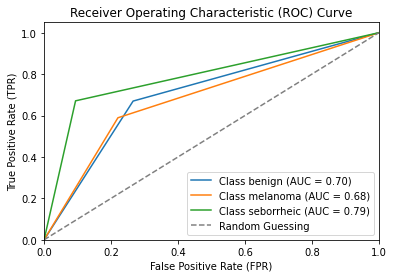

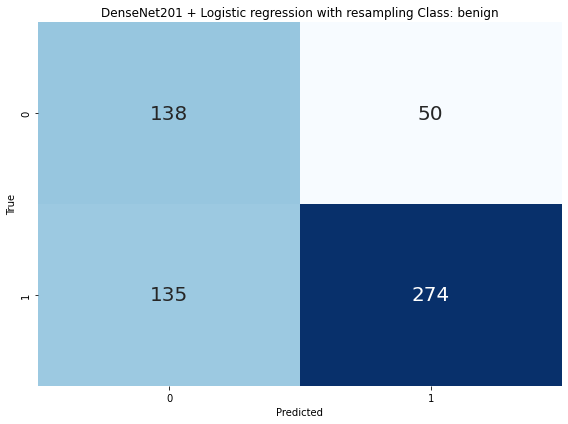

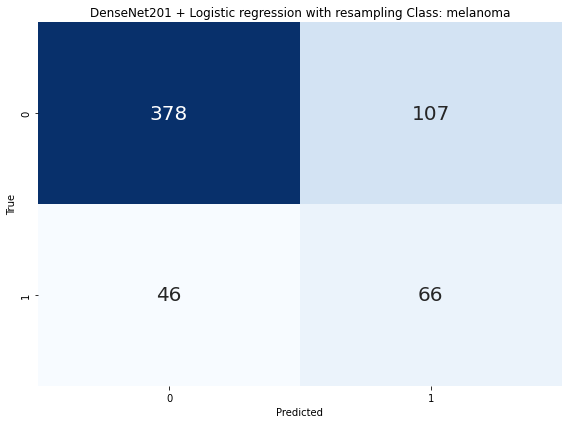

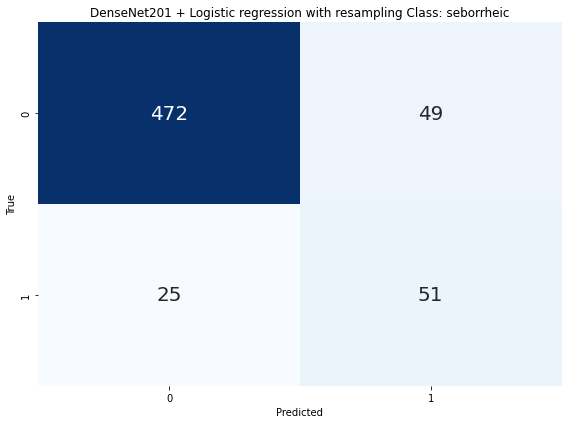

In [13]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

# Calculate the balanced multiclass accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced multiclass accuracy: ", balanced_accuracy)

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)
classes=['benign','melanoma','seborrheic']

for class_label in range(3):
    tp = mcm[class_label, 1, 1]
    fp = mcm[class_label, 0, 1]
    fn = mcm[class_label, 1, 0]
    tn = mcm[class_label, 0, 0]

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    print("Class:", classes[class_label])
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    
    print("Precision:", precision)
    print("F1-score:", f1)
    print()

    binary_true_labels = np.where(np.array(y_test) == class_label, 1, 0)
    binary_predicted_labels = np.where(np.array(y_pred) == class_label, 1, 0)

    # Compute FPR and TPR for each class
    fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='Class ' +classes[class_label] +' (AUC = {:.2f})'.format(roc_auc))

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Iterate over each class and create heatmap
for i, class_label in enumerate(classes):
    # Create a separate plot for each class
    plt.figure(figsize=(8, 6))
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.title('DenseNet201 + Logistic regression with resampling Class: ' + class_label)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

### Lasso + RFE + SVM with weighted classes for handling class imbalance

##### Lasso without resampled data + RFE for feature selection

In [ ]:
# Create an instance of LassoCV
lasso_cv = LassoCV(cv=10)  # You can adjust the number of cross-validation folds (cv) as needed

# Fit LassoCV to the data
lasso_cv.fit(df_scaled_train, y_train)

# Get the optimal alpha value
optimal_alpha = lasso_cv.alpha_

# Create an instance of the Lasso regression model
lasso = Lasso(alpha=optimal_alpha)  # You can adjust the regularization strength (alpha) as needed

# Fit the Lasso model to the data
lasso.fit(df_scaled_train, y_train)

# Obtain the coefficients of the Lasso model
coefficients = lasso.coef_

# Get the feature names corresponding to the non-zero coefficients
selected_features = df_scaled_train.columns[coefficients != 0]

# Create a new dataframe with the selected features
df_selected_train_Lasso_noResampling = df_scaled_train[selected_features]
print(df_selected_train_Lasso_noResampling.shape)

df_selected_test_Lasso_noResampling = df_scaled_test[selected_features]
df_selected_train_Lasso_noResampling.to_csv("/Users/clara/Desktop/MAIA/MLDL/features_train_Lasso_noResampling.csv", index=False)
df_selected_test_Lasso_noResampling.to_csv("/Users/clara/Desktop/MAIA/MLDL/features_test_Lasso_noResampling.csv", index=False)

In [27]:
# Read the features from csv files if the session is closed
df_selected_train_Lasso_noResampling = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/features_train_Lasso_noResampling.csv")
df_selected_test_Lasso_noResampling = pd.read_csv("/Users/clara/Desktop/MAIA/MLDL/features_test_Lasso_noResampling.csv")

In [ ]:
# RFE for feature selection using SVM as reference model
estimator = SVC(kernel='linear', decision_function_shape='ovr',class_weight='balanced')
num_features_to_select = 75  # Specify the desired number of features
rfe = RFE(estimator, n_features_to_select=num_features_to_select)
rfe.fit(df_selected_train_Lasso_noResampling, y_train)
selected_features_rfeSVM = rfe.support_

# Obtain indexes of True features
true_feature_indexes = np.where(selected_features_rfeSVM)[0]

# Print the indexes
print(true_feature_indexes)

# Filter the dataframe to keep only the true features
df_features_train_selected = df_selected_train_Lasso_noResampling.iloc[:, true_feature_indexes]
#df_features_train_selected.head()

df_features_test_selected = df_selected_test_Lasso_noResampling.iloc[:, true_feature_indexes]
df_features_train_selected.shape

##### SVM with cross-validation and grid-search, and weighted classes for dealing with class imbalance

In [29]:
# Set up the SVM classifier
svm_classifier = svm.SVC()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=10)
grid_search.fit(df_features_train_selected, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Perform 10-fold cross-validation with the best hyperparameters
svm_classifier_best = svm.SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'],
                             gamma=grid_search.best_params_['gamma'], decision_function_shape='ovr',class_weight='balanced')
cv_scores = cross_val_score(svm_classifier_best, df_features_train_selected, y_train, cv=10)
print(cv_scores)

Best hyperparameters:  {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
[0.75       0.67142857 0.73571429 0.72142857 0.7        0.71428571
 0.73571429 0.68345324 0.6618705  0.66906475]


Mean accuracy 0.7042959917780063
Standard deviation accuracy 0.03005112384473482
Balanced multiclass accuracy:  0.6775036613538736
Class: benign
Specificity: 0.7553191489361702
Sensitivity: 0.6528117359413202
Precision: 0.853035143769968
F1-score: 0.7396121883656509

Class: melanoma
Specificity: 0.7690721649484537
Sensitivity: 0.6428571428571429
Precision: 0.391304347826087
F1-score: 0.4864864864864865

Class: seborrheic
Specificity: 0.9155470249520153
Sensitivity: 0.7368421052631579
Precision: 0.56
F1-score: 0.6363636363636364


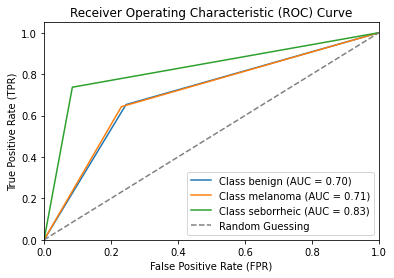

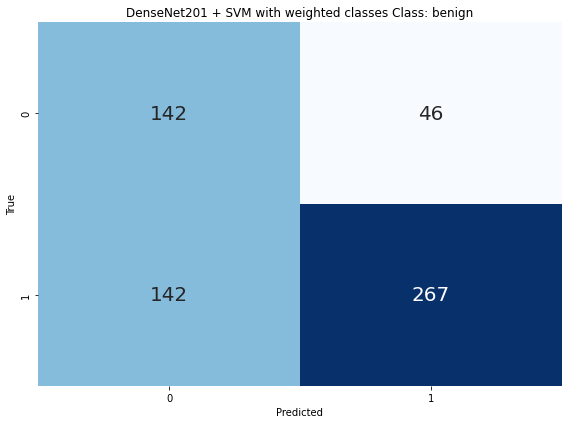

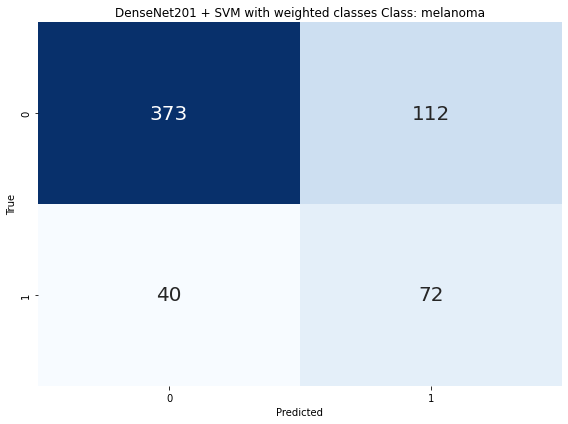

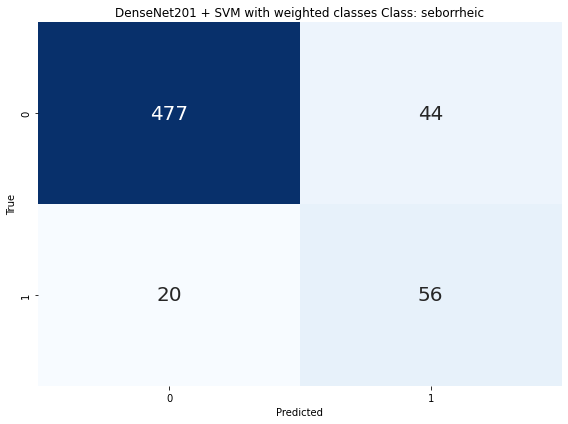

In [30]:
accuracy_mean = np.mean(cv_scores)
accuracy_stdev = np.std(cv_scores)
print("Mean accuracy", accuracy_mean)
print("Standard deviation accuracy", accuracy_stdev)

# Fit the SVM model to the training data
svm_classifier_best.fit(df_features_train_selected, y_train)
y_pred_svm = svm_classifier_best.predict(df_features_test_selected)
# Calculate the balanced multiclass accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_svm)
print("Balanced multiclass accuracy: ", balanced_accuracy)

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred_svm)
classes=['benign','melanoma','seborrheic']

for class_label in range(3):
    tp = mcm[class_label, 1, 1]
    fp = mcm[class_label, 0, 1]
    fn = mcm[class_label, 1, 0]
    tn = mcm[class_label, 0, 0]

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    print("Class:", classes[class_label])
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    
    print("Precision:", precision)
    print("F1-score:", f1)
    print()

    binary_true_labels = np.where(np.array(y_test) == class_label, 1, 0)
    binary_predicted_labels = np.where(np.array(y_pred_svm) == class_label, 1, 0)

    # Compute FPR and TPR for each class
    fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='Class ' +classes[class_label] +' (AUC = {:.2f})'.format(roc_auc))

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Iterate over each class and create heatmap
for i, class_label in enumerate(classes):
    # Create a separate plot for each class
    plt.figure(figsize=(8, 6))
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.title('DenseNet201 + SVM with weighted classes Class: ' + class_label)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

### Logistic regression using class weights for handling class imbalance + Lasso + RFE

In [ ]:
estimator = LogisticRegression(class_weight='balanced', multi_class='ovr')
num_features_to_select = 75  # Specify the desired number of features
rfe = RFE(estimator, n_features_to_select=num_features_to_select)
rfe.fit(df_selected_train_Lasso_noResampling, y_train)
selected_features_rfeLR = rfe.support_
print(selected_features_rfeLR)

# Obtain indexes of True features
true_feature_indexes = np.where(selected_features_rfeLR)[0]

# Print the indexes
print(true_feature_indexes)

# Filter the dataframe to keep only the true features
df_features_train_selected = df_selected_train_Lasso_noResampling.iloc[:, true_feature_indexes]
#df_features_train_selected.head()

df_features_test_selected = df_selected_test_Lasso_noResampling.iloc[:, true_feature_indexes]
df_features_train_selected.shape

In [ ]:
#### TUNING OF LR
# Create an instance of the Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', multi_class='ovr')

# Define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(df_features_train_selected, y_train)

# Get the best parameter combination
best_params = grid_search.best_params_

# Print the best parameter combination
print("Best parameters:", best_params)


# Create a new Logistic Regression model with the best parameters
logreg = LogisticRegression(penalty=grid_search.best_params_['penalty'], C=grid_search.best_params_['C'], solver=grid_search.best_params_['solver'],class_weight='balanced', multi_class='ovr')

# Fit the model to the training data
logreg.fit(df_features_train_selected, y_train)

# Make predictions on the validation data
y_pred = logreg.predict(df_features_test_selected)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

Accuracy: 0.7236180904522613
Balanced multiclass accuracy:  0.6780601411842565
Class: benign
Specificity: 0.675531914893617
Sensitivity: 0.7799511002444988
Precision: 0.8394736842105263
F1-score: 0.8086185044359949

Class: melanoma
Specificity: 0.8701030927835052
Sensitivity: 0.49107142857142855
Precision: 0.4661016949152542
F1-score: 0.4782608695652174

Class: seborrheic
Specificity: 0.9213051823416507
Sensitivity: 0.7631578947368421
Precision: 0.5858585858585859
F1-score: 0.6628571428571428


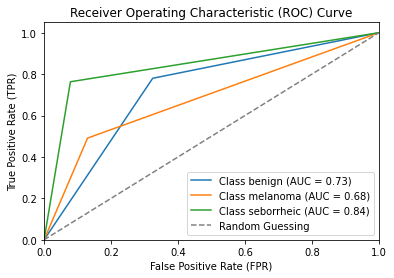

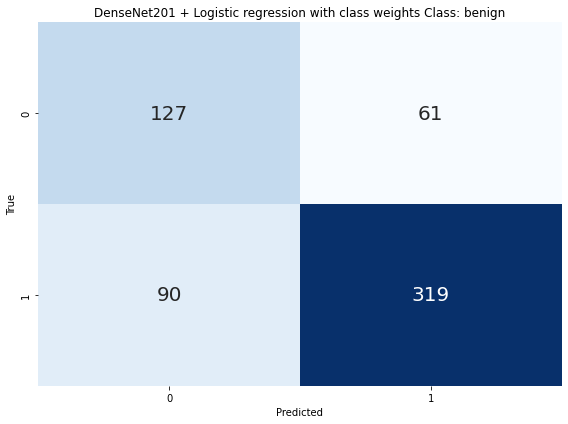

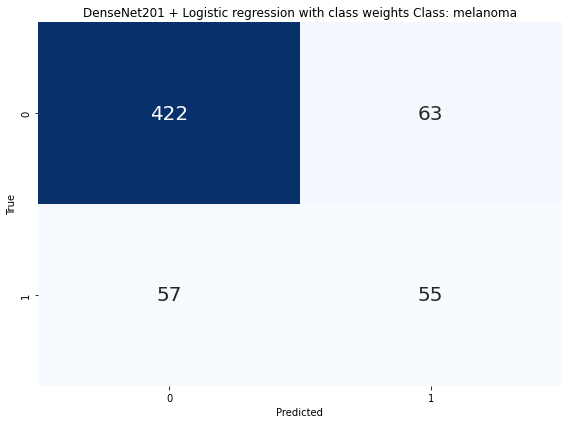

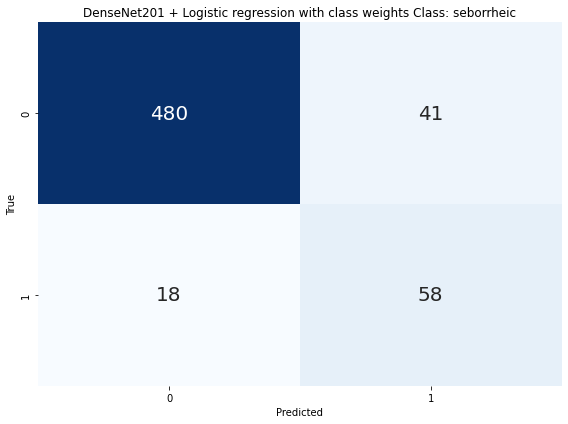

In [36]:
# Print the accuracy score
print("Accuracy:", accuracy)

# Calculate the balanced multiclass accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced multiclass accuracy: ", balanced_accuracy)

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)
classes=['benign','melanoma','seborrheic']

for class_label in range(3):
    tp = mcm[class_label, 1, 1]
    fp = mcm[class_label, 0, 1]
    fn = mcm[class_label, 1, 0]
    tn = mcm[class_label, 0, 0]

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    print("Class:", classes[class_label])
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    
    print("Precision:", precision)
    print("F1-score:", f1)
    print()

    binary_true_labels = np.where(np.array(y_test) == class_label, 1, 0)
    binary_predicted_labels = np.where(np.array(y_pred) == class_label, 1, 0)

    # Compute FPR and TPR for each class
    fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='Class ' +classes[class_label] +' (AUC = {:.2f})'.format(roc_auc))

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Iterate over each class and create heatmap
for i, class_label in enumerate(classes):
    # Create a separate plot for each class
    plt.figure(figsize=(8, 6))
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.title('DenseNet201 + Logistic regression with class weights Class: ' + class_label)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

### Random Forest classifier + Lasso + RFE + weighted classes for handling class imbalance

In [37]:
# Create an instance of the Random Forest model
rf = RandomForestClassifier(class_weight='balanced')

# Define the number of features to select
num_features_to_select = 75

# Create an instance of RFE with the Random Forest estimator
rfe = RFE(rf, n_features_to_select=num_features_to_select)

# Fit RFE to the training data
rfe.fit(df_selected_train_Lasso_noResampling, y_train)

# Get the selected features
selected_features_rfeRF = rfe.support_

# Obtain indexes of True features
true_feature_indexes = np.where(selected_features_rfeRF)[0]

# Filter the dataframe to keep only the true features
df_features_train_selected = df_selected_train_Lasso_noResampling.iloc[:, true_feature_indexes]
df_features_test_selected = df_selected_test_Lasso_noResampling.iloc[:, true_feature_indexes]

In [38]:
### TUNING OF RANDOM FOREST CLASSIFIER
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(df_features_train_selected, y_train)

# Get the best parameter combination
best_params = grid_search.best_params_

# Print the best parameter combination
print("Best parameters:", best_params)


# Create a new Random Forest model with the best parameters
rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                            max_depth=grid_search.best_params_['max_depth'],
                            min_samples_split=grid_search.best_params_['min_samples_split'],
                            min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                            class_weight='balanced')

# Fit the model to the training data
rf.fit(df_features_train_selected, y_train)

# Make predictions on the validation data
y_pred = rf.predict(df_features_test_selected)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


Accuracy: 0.7788944723618091
Balanced multiclass accuracy:  0.6480125282644263
Class: benign
Specificity: 0.4946808510638298
Sensitivity: 0.9266503667481663
Precision: 0.79957805907173
F1-score: 0.8584371460928653

Class: melanoma
Specificity: 0.9731958762886598
Sensitivity: 0.24107142857142858
Precision: 0.675
F1-score: 0.35526315789473684

Class: seborrheic
Specificity: 0.9539347408829175
Sensitivity: 0.7763157894736842
Precision: 0.7108433734939759
F1-score: 0.7421383647798742


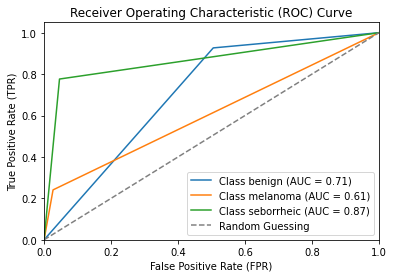

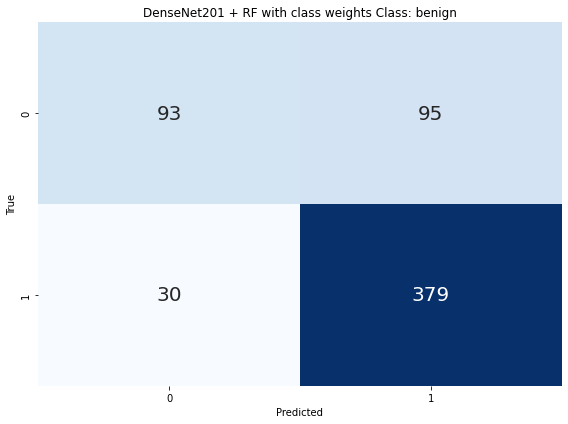

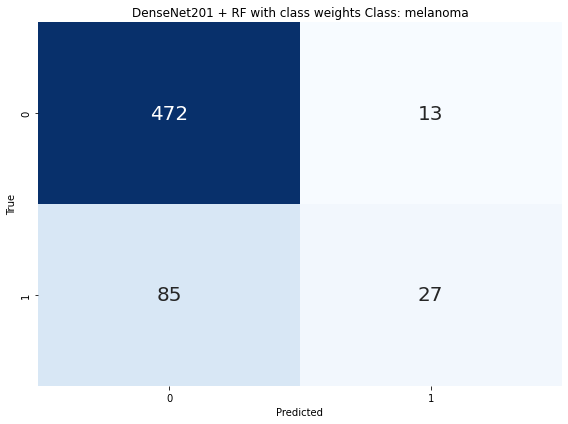

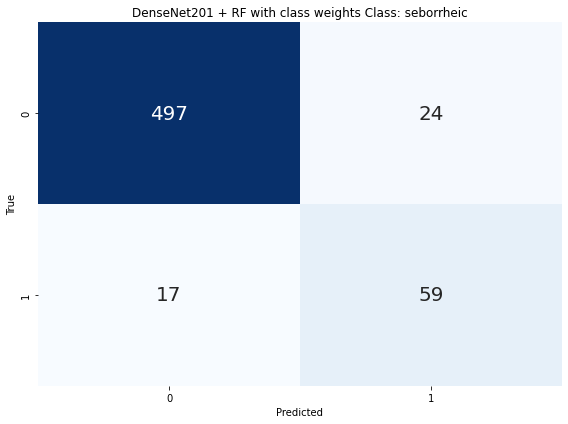

In [39]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

# Calculate the balanced multiclass accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced multiclass accuracy: ", balanced_accuracy)

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)
classes=['benign','melanoma','seborrheic']

for class_label in range(3):
    tp = mcm[class_label, 1, 1]
    fp = mcm[class_label, 0, 1]
    fn = mcm[class_label, 1, 0]
    tn = mcm[class_label, 0, 0]

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    print("Class:", classes[class_label])
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    
    print("Precision:", precision)
    print("F1-score:", f1)
    print()

    binary_true_labels = np.where(np.array(y_test) == class_label, 1, 0)
    binary_predicted_labels = np.where(np.array(y_pred) == class_label, 1, 0)

    # Compute FPR and TPR for each class
    fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='Class ' +classes[class_label] +' (AUC = {:.2f})'.format(roc_auc))

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Iterate over each class and create heatmap
for i, class_label in enumerate(classes):
    # Create a separate plot for each class
    plt.figure(figsize=(8, 6))
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.title('DenseNet201 + RF with class weights Class: ' + class_label)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

### KNN classifier + Lasso + RFE + weighted classes for handling class imbalance

In [40]:
# Perform univariate feature selection
k_best = SelectKBest(score_func=mutual_info_classif, k=75)
df_features_train_selected = k_best.fit_transform(df_selected_train_Lasso_noResampling, y_train)
df_features_test_selected = k_best.transform(df_selected_test_Lasso_noResampling)

In [42]:
knn = KNeighborsClassifier()
# Create the parameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(df_features_train_selected, y_train)

# Get the best parameter combination
best_params = grid_search.best_params_

# Print the best parameter combination
print("Best parameters:", best_params)

# Create a new KNN model with the best parameters and balanced class weights
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], 
                            weights=best_params['weights'])

# Fit the model to the training data
knn.fit(df_features_train_selected, y_train)

# Make predictions on the validation data
y_pred = knn.predict(df_features_test_selected)

Best parameters: {'n_neighbors': 7, 'weights': 'distance'}


Accuracy: 0.7169179229480737
Balanced multiclass accuracy:  0.5506676226017366
Class: benign
Specificity: 0.4308510638297872
Sensitivity: 0.8850855745721271
Precision: 0.7718550106609808
F1-score: 0.824601366742597

Class: melanoma
Specificity: 0.9072164948453608
Sensitivity: 0.21428571428571427
Precision: 0.34782608695652173
F1-score: 0.2651933701657458

Class: seborrheic
Specificity: 0.9673704414587332
Sensitivity: 0.5526315789473685
Precision: 0.711864406779661
F1-score: 0.6222222222222223


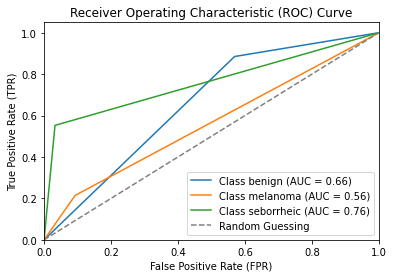

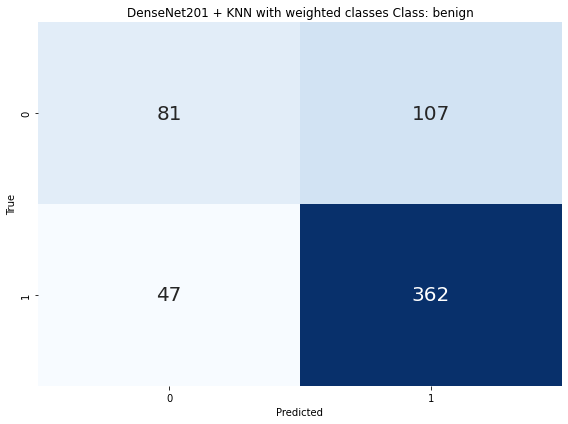

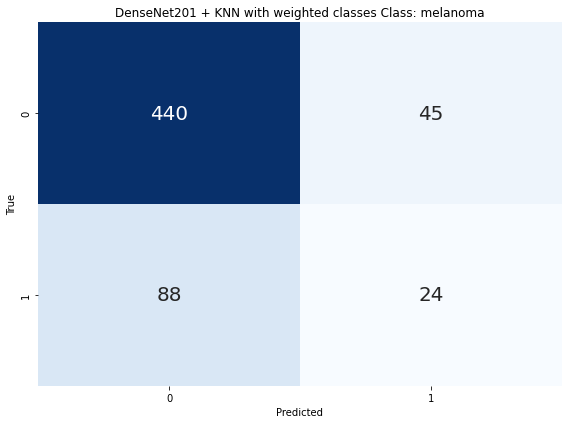

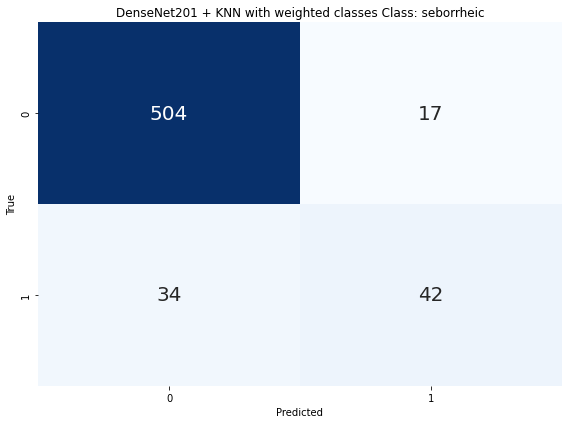

In [43]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

# Calculate the balanced multiclass accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced multiclass accuracy: ", balanced_accuracy)

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)
classes=['benign','melanoma','seborrheic']

for class_label in range(3):
    tp = mcm[class_label, 1, 1]
    fp = mcm[class_label, 0, 1]
    fn = mcm[class_label, 1, 0]
    tn = mcm[class_label, 0, 0]

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    print("Class:", classes[class_label])
    print("Specificity:", specificity)
    print("Sensitivity:", sensitivity)
    
    print("Precision:", precision)
    print("F1-score:", f1)
    print()

    binary_true_labels = np.where(np.array(y_test) == class_label, 1, 0)
    binary_predicted_labels = np.where(np.array(y_pred) == class_label, 1, 0)

    # Compute FPR and TPR for each class
    fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='Class ' +classes[class_label] +' (AUC = {:.2f})'.format(roc_auc))

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Iterate over each class and create heatmap
for i, class_label in enumerate(classes):
    # Create a separate plot for each class
    plt.figure(figsize=(8, 6))
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.title('DenseNet201 + KNN with weighted classes Class: ' + class_label)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()